# charts.ipynb

This notebook generates figures that track the fluctuation in various HbA1c measures during the COVID-19 pandemic.

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from functools import reduce
from glob import glob

pd.options.mode.chained_assignment = None

## Data Import and Cleaning

In [2]:
fpath = "../output/data"

In [3]:
# Create total dataframes
df_total = pd.read_csv(f"{fpath}/measure_total_tests_by_dm.csv").drop(columns=['value'])
df_gt48_dm = pd.read_csv(f"{fpath}/measure_tests_gt48_by_dm.csv").drop(columns=['value','population'])
df_gt58_dm = pd.read_csv(f"{fpath}/measure_tests_gt58_by_dm.csv").drop(columns=['value','population'])
df_gt64_dm = pd.read_csv(f"{fpath}/measure_tests_gt64_by_dm.csv").drop(columns=['value','population'])
df_gt75_dm = pd.read_csv(f"{fpath}/measure_tests_gt75_by_dm.csv").drop(columns=['value','population'])
base_dfs = [df_total, df_gt48_dm, df_gt58_dm, df_gt64_dm, df_gt75_dm]

In [4]:
df_total = reduce(lambda left,right: pd.merge(left,right,on=['diabetes_type','date']), base_dfs)
df_total['date'] = df_total['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
df_total_nodm = df_total.loc[df_total.diabetes_type == 'NO_DM']
df_total_t1dm = df_total.loc[df_total.diabetes_type == 'T1DM']
df_total_t2dm = df_total.loc[df_total.diabetes_type == 'T2DM']

In [5]:
# Recode variables
dict_eth = {1: 'White', 2: 'Mixed', 3: 'Asian',
            4: 'Black', 5: 'Other', np.nan: 'Unknown',
            0: 'Unknown'}

dict_imd = {0: 'Unknown', 1: '1 Most deprived', 2: '2',
            3: '3', 4: '4', 5: '5 Least deprived'}

dict_ld = {1:'Yes', 0:'No'}

In [6]:
# Create lists of dataframes broken down by demographics
def create_subdf(th):
    demos = ['age', 'sex', 'ethnicity', 'region', 'imd', 'ld', 'mi']
    li_df = []
    li_df_t1dm = []
    li_df_t2dm = []
    for d in demos:
        df_all = pd.read_csv(f"{fpath}/measure_{th}_by_dm_and_{d}.csv")
        df_all['tests_per_1000'] = df_all['value']*1000
        df_all['date'] = df_all['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
        
        if d == 'age':
            df_all = df_all.loc[df_all.age_group != '0-15']
        
        if d == 'ethnicity':
            # Format ethnicity
            df_all = df_all.replace({"ethnicity": dict_eth})
            
        if d == 'imd':
            # Format IMD 
            df_all = df_all.replace({'imd': dict_imd})
        
        if d == 'ld':
            # Format learning disability label
            df_all = df_all.replace({'learning_disability': dict_ld})
        
        df_nodm = df_all.loc[df_all.diabetes_type == 'NO_DM']
        df_t1dm = df_all.loc[df_all.diabetes_type == 'T1DM']
        df_t2dm = df_all.loc[df_all.diabetes_type == 'T2DM']
        li_df.append(df_nodm)
        li_df_t1dm.append(df_t1dm)
        li_df_t2dm.append(df_t2dm)
   
    return li_df, li_df_t1dm, li_df_t2dm

li_df, li_df_t1dm, li_df_t2dm = create_subdf('total_tests')
li_df_gt48, li_df_t1dm_gt48, li_df_t2dm_gt48 = create_subdf('tests_gt48')
li_df_gt58, li_df_t1dm_gt58, li_df_t2dm_gt58 = create_subdf('tests_gt58')
li_df_gt64, li_df_t1dm_gt64, li_df_t2dm_gt64 = create_subdf('tests_gt64')
li_df_gt75, li_df_t1dm_gt75, li_df_t2dm_gt75 = create_subdf('tests_gt75')

In [7]:
# Create percentage of tests by threshold    
def create_pct(df_in, var):
    df_in[var + '_pct'] = (df_in[var]/df_in['took_hba1c'])*100

In [8]:
thresholds = ['hba1c_gt_48', 'hba1c_gt_58', 'hba1c_gt_64', 'hba1c_gt_75']
for t in thresholds:
    create_pct(df_total_nodm, t)
    create_pct(df_total_t1dm, t)
    create_pct(df_total_t2dm, t)

In [9]:
# Concatenate thresholds by demographics for patients with T2DM
drop_col = ['population','value','tests_per_1000']
demo_vars = ['age_group', 'sex', 'ethnicity', 'region', 'imd', 'learning_disability', 'mental_illness']

df_thresholds = []
for i in range(0,len(li_df)):
    dfs = []
    dfs.append(li_df_t2dm[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt48[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt58[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt64[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt75[i].drop(columns=drop_col))
    df_concat = reduce(lambda left,right: pd.merge(left,right,on=['diabetes_type','date',demo_vars[i]]), dfs)
    for t in thresholds:
        create_pct(df_concat, t)
    df_thresholds.append(df_concat)

In [10]:
# Functions to generate charts
def create_chart(title, df, ax):
    sns.lineplot(x='date', y='took_hba1c', data=df, 
                 ax=ax, label="All Tests", ci=None)
    
    # Set title and make axes labels empty
    ax.fill_between(df.date, df.hba1c_gt_48.min(), 
                    df.hba1c_gt_48, facecolor='blue', alpha=0.15, label='HbA1c > 48')
    ax.fill_between(df.date, df.hba1c_gt_58.min(), 
                    df.hba1c_gt_58, facecolor='blue', alpha=0.45, label='HbA1c > 58')
    ax.fill_between(df.date, df.hba1c_gt_64.min(), 
                    df.hba1c_gt_64, facecolor='blue', alpha=0.65, label='HbA1c > 64')
    ax.fill_between(df.date, df.hba1c_gt_75.min(),
                    df.hba1c_gt_75, facecolor='blue', alpha=1, label='HbA1c > 75')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    
def create_subplot(measure, group, title, df, ax):
    # Create the scatter plot
    sns.lineplot(x='date', y=measure,
                 hue=group, data=df, ax=ax)
    # Set title and make axes labels empty
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

def create_plotgrid(measure, dfs, ylabel, filename, title):
    fig2, axes2 = plt.subplots(4, 2, figsize=(16,24), sharex=True, sharey=True)
    fig2.delaxes(ax=axes2[3,1])

    create_subplot(measure, 'age_group', 'Age Group', 
                   dfs[0].loc[dfs[0].age_group != 'missing'], axes2[0,0])
    create_subplot(measure, 'sex', 'Sex', 
                   dfs[1].loc[dfs[1].sex.isin(['F','M'])], axes2[0,1])
    create_subplot(measure, 'ethnicity', 'Ethnicity', 
                   dfs[2], axes2[1,0])
    create_subplot(measure, 'region', 'Region', 
                   dfs[3], axes2[1,1])
    create_subplot(measure, 'imd', 'IMD', 
                   dfs[4], axes2[2,0])
    create_subplot(measure, 'learning_disability', 'Learning Disability', 
                   dfs[5], axes2[2,1])
    create_subplot(measure, 'mental_illness', 'Mental Illness', 
                   dfs[6], axes2[3,0])

    # Set axes labels
    plt.setp(axes2[-1, :],
             xlabel='Date')
    plt.setp(axes2[:, 0],
             ylabel=ylabel)
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.suptitle(title, fontsize=16)
    plt.savefig('../output/' + filename + '.png')
    plt.show()

_______

## Total Number

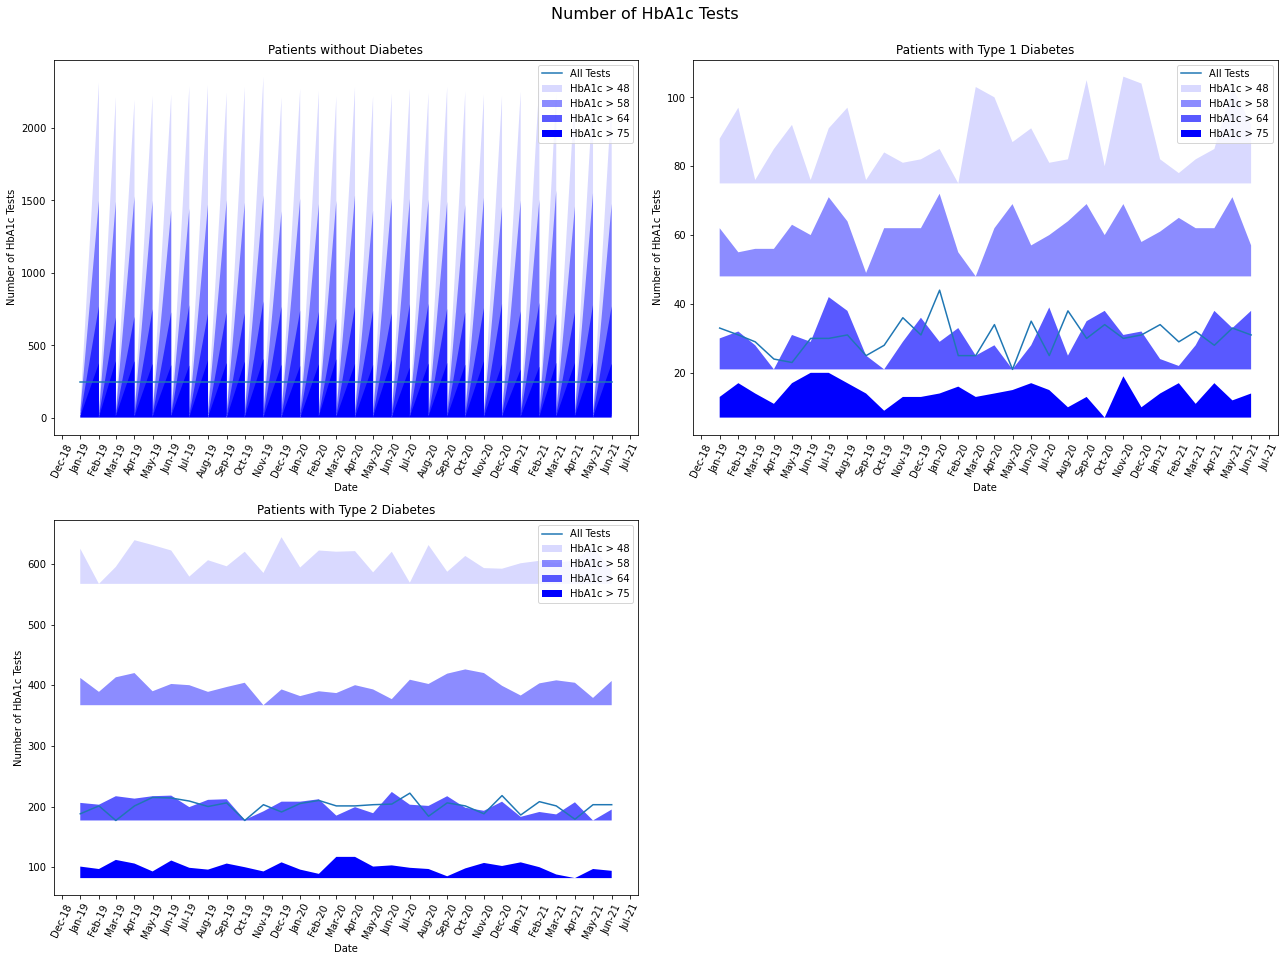

In [11]:
# Total number
fig, axes = plt.subplots(2,2, figsize=(18, 14))
fig.delaxes(ax=axes[1,1])
create_chart('Patients without Diabetes', df_total, axes[0,0])
create_chart('Patients with Type 1 Diabetes', df_total_t1dm, axes[0,1])
create_chart('Patients with Type 2 Diabetes', df_total_t2dm, axes[1,0])

fig.suptitle('Number of HbA1c Tests', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('../output/total_by_dm.png')
plt.show()

### By Demographics

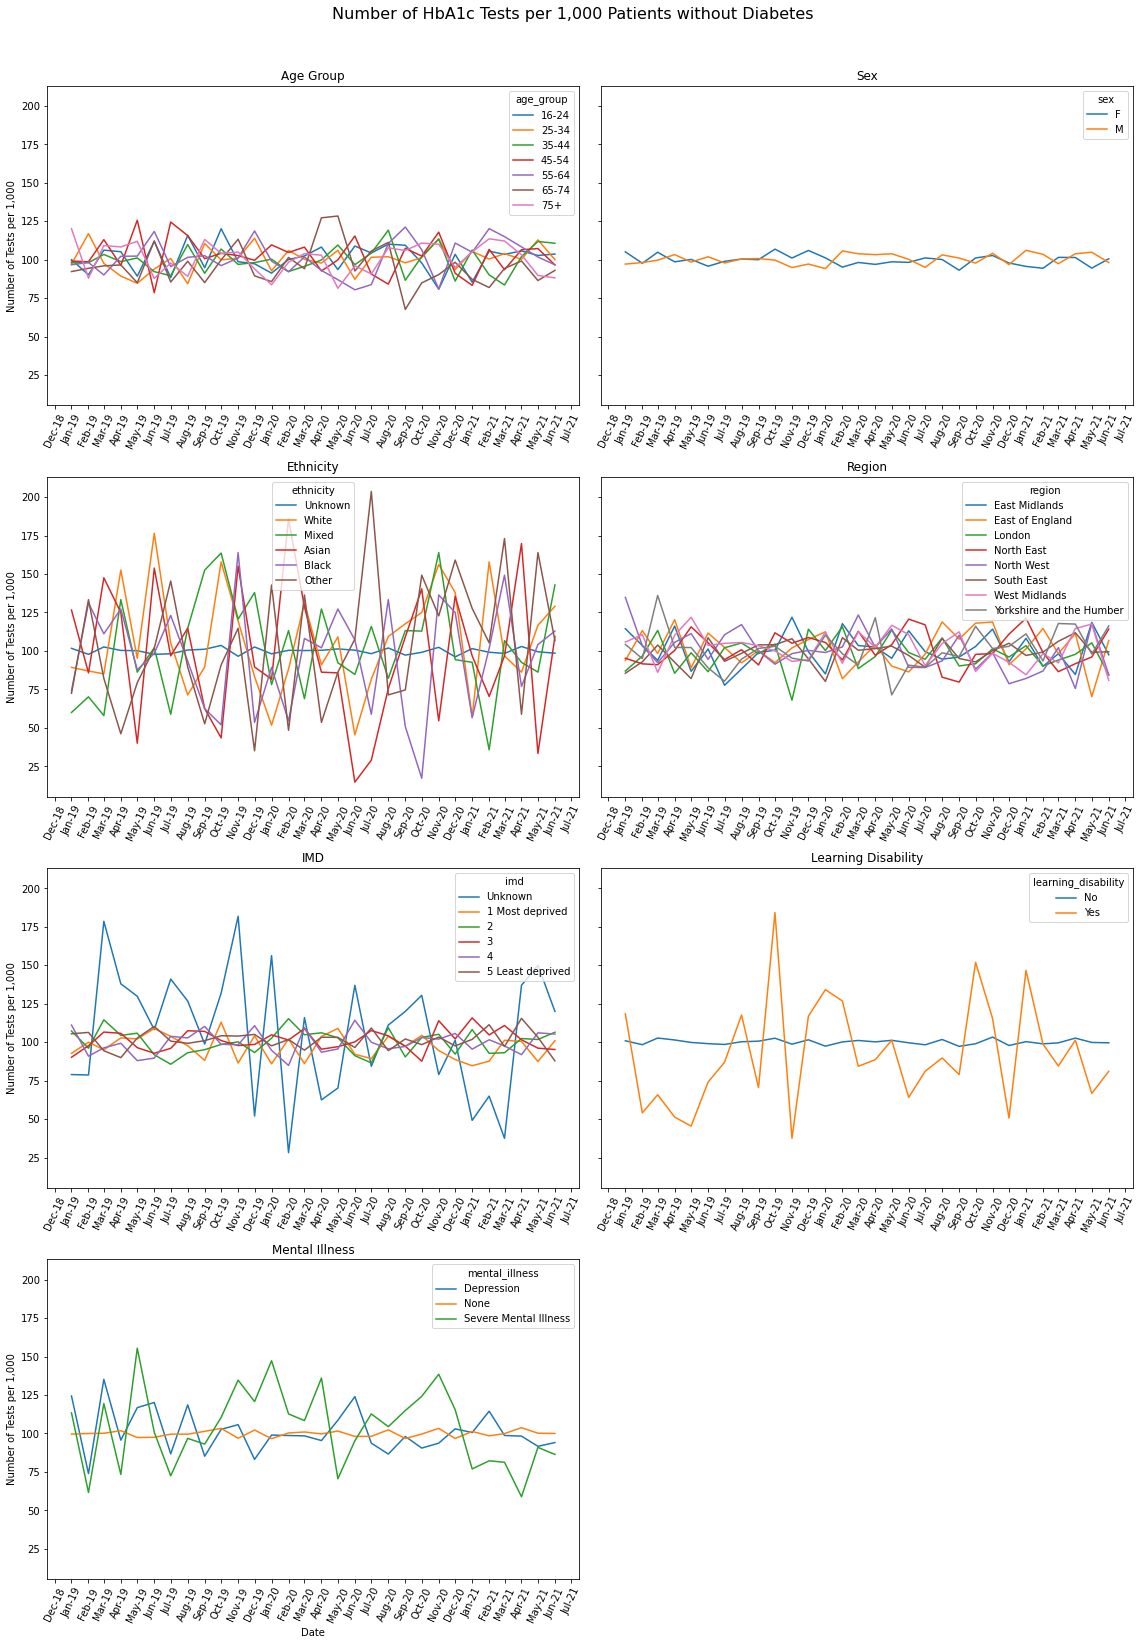

In [12]:
# Patients without diabetes
create_plotgrid('tests_per_1000', li_df, 'Number of Tests per 1,000',
                'total_nodm_by_group', 'Number of HbA1c Tests per 1,000 Patients without Diabetes')

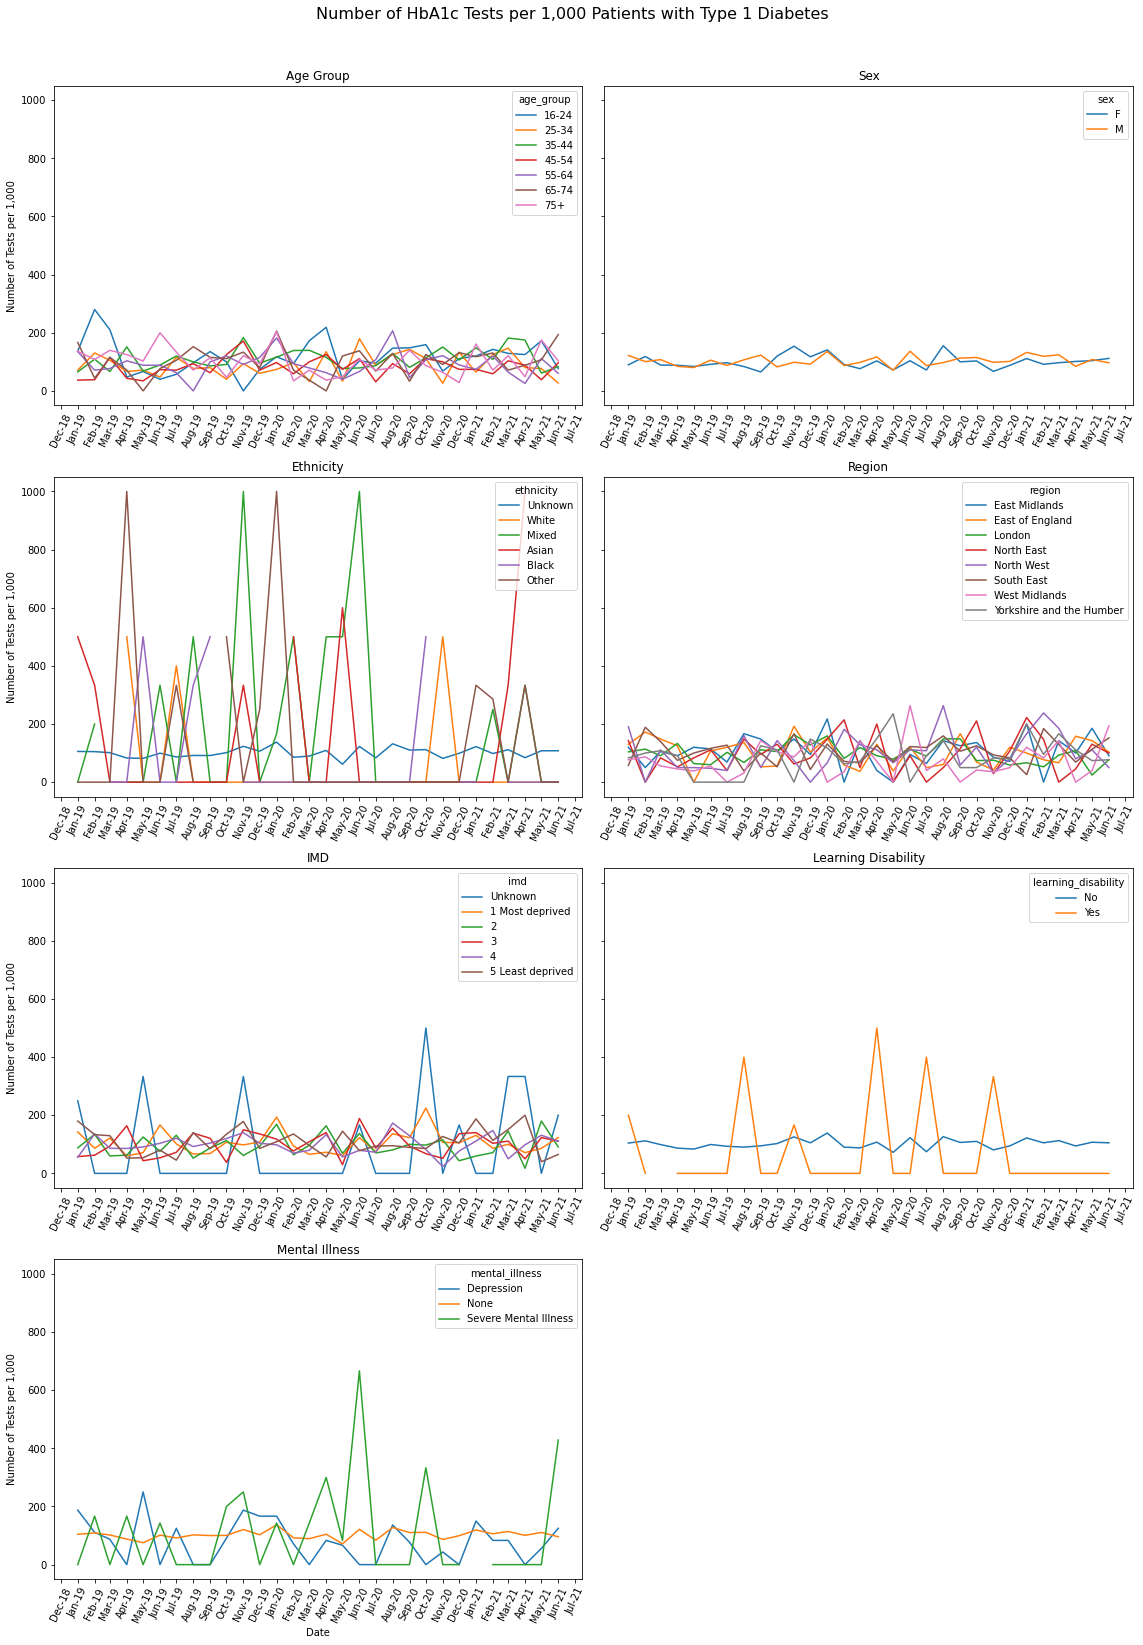

In [13]:
# Patients with T1DM
create_plotgrid('tests_per_1000',li_df_t1dm, 'Number of Tests per 1,000',
                'total_t1dm_by_group', 'Number of HbA1c Tests per 1,000 Patients with Type 1 Diabetes')

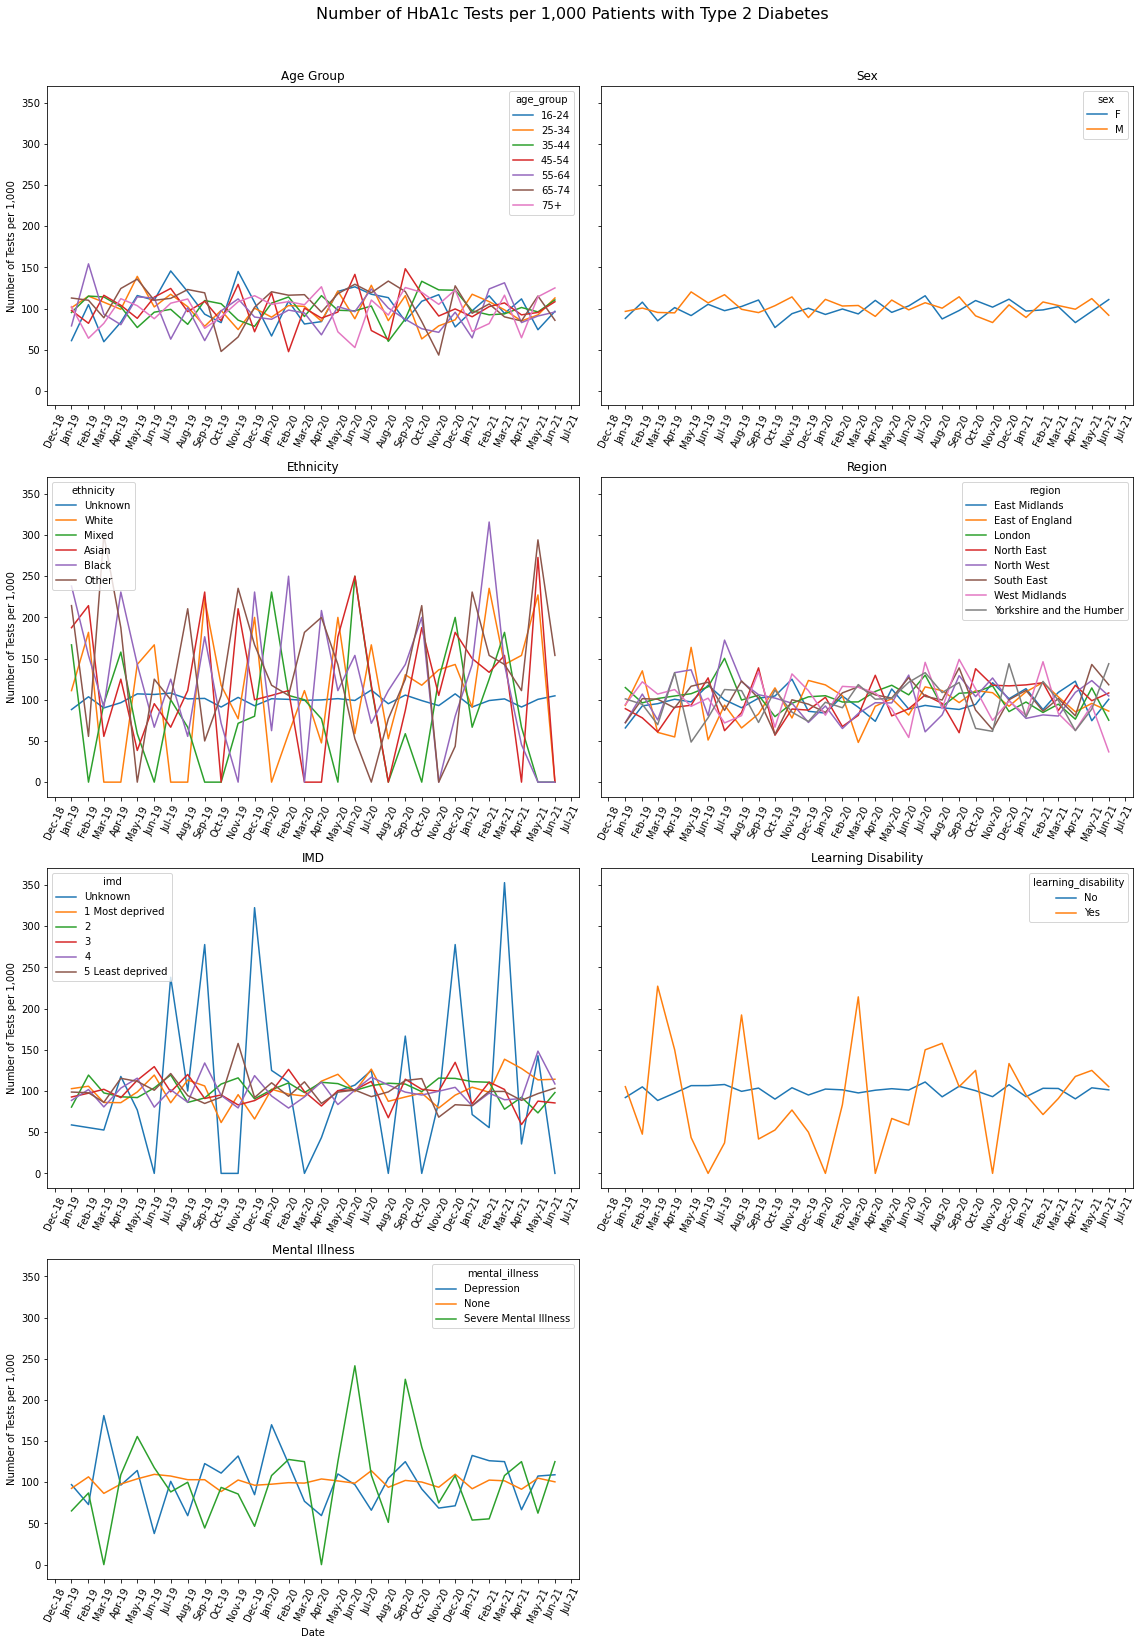

In [14]:
# Patients with T2DM
create_plotgrid('tests_per_1000', li_df_t2dm, 'Number of Tests per 1,000',
                'total_t2dm_by_group', 'Number of HbA1c Tests per 1,000 Patients with Type 2 Diabetes')

_________

## Tests by Threshold for Those with T2DM

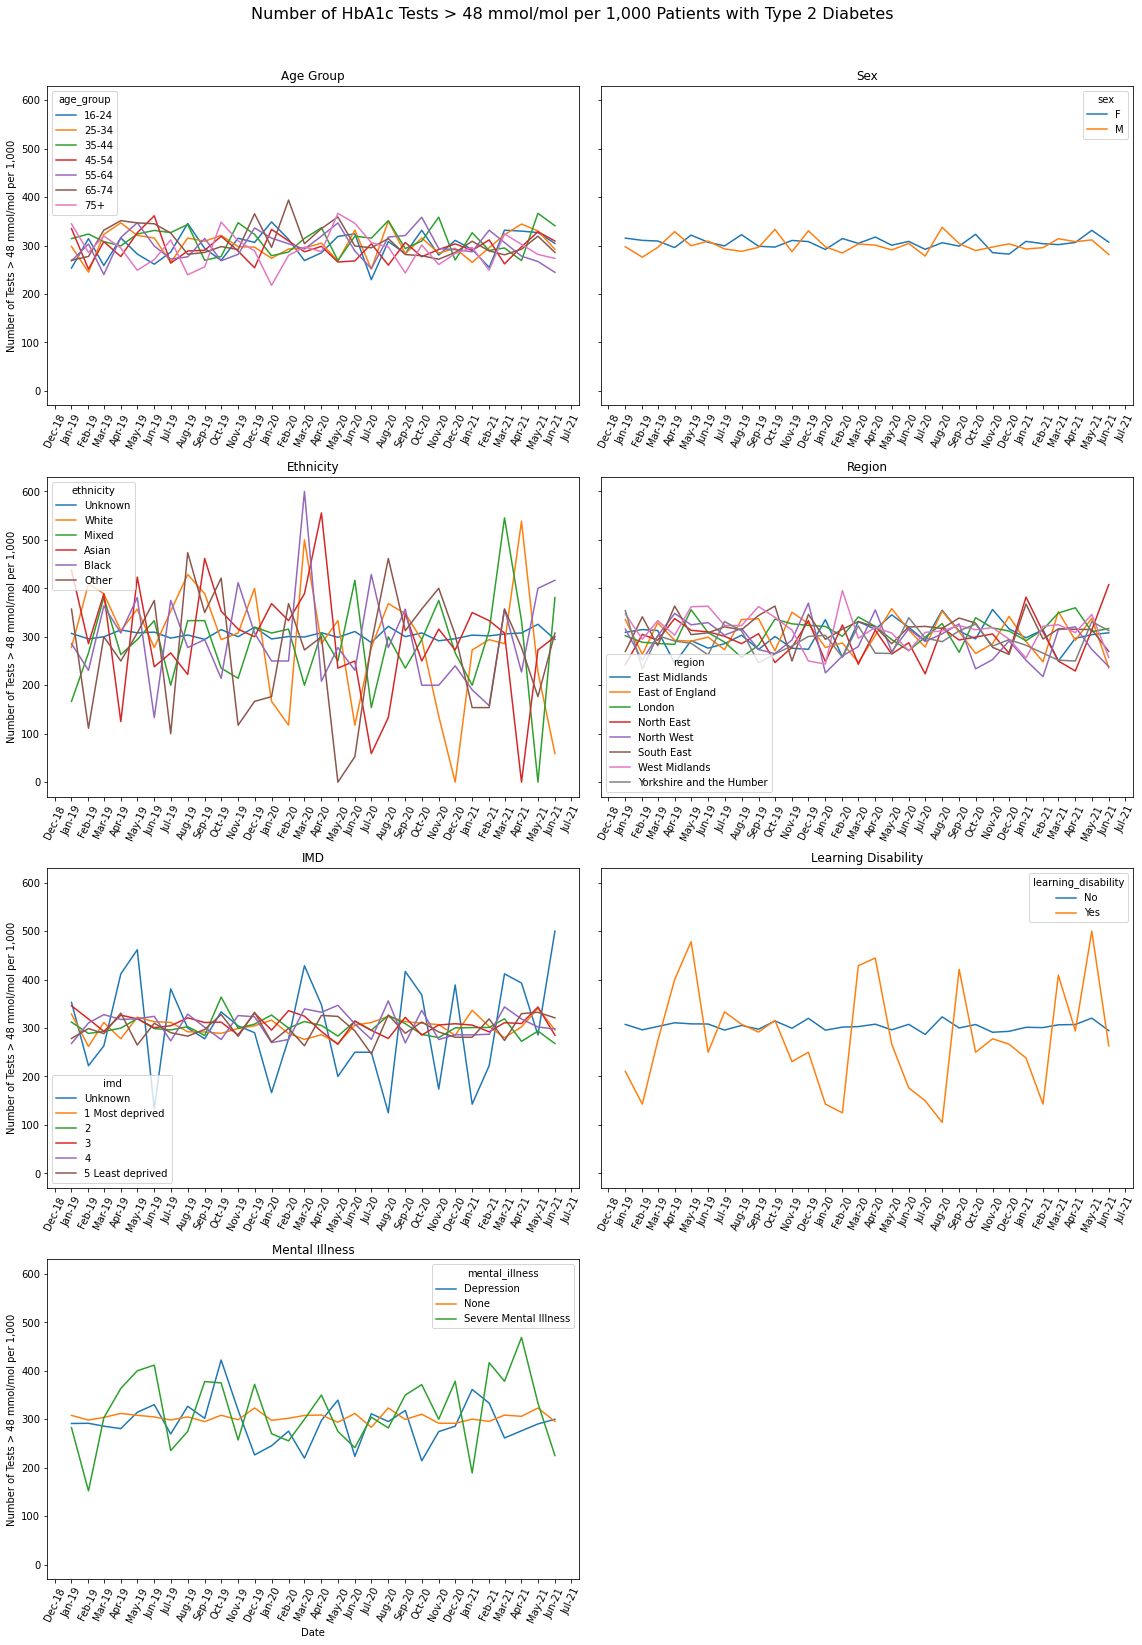

In [15]:
# > 48
create_plotgrid('tests_per_1000',li_df_t2dm_gt48, 'Number of Tests > 48 mmol/mol per 1,000',
                'gt48_t2dm_by_group', 'Number of HbA1c Tests > 48 mmol/mol per 1,000 Patients with Type 2 Diabetes')

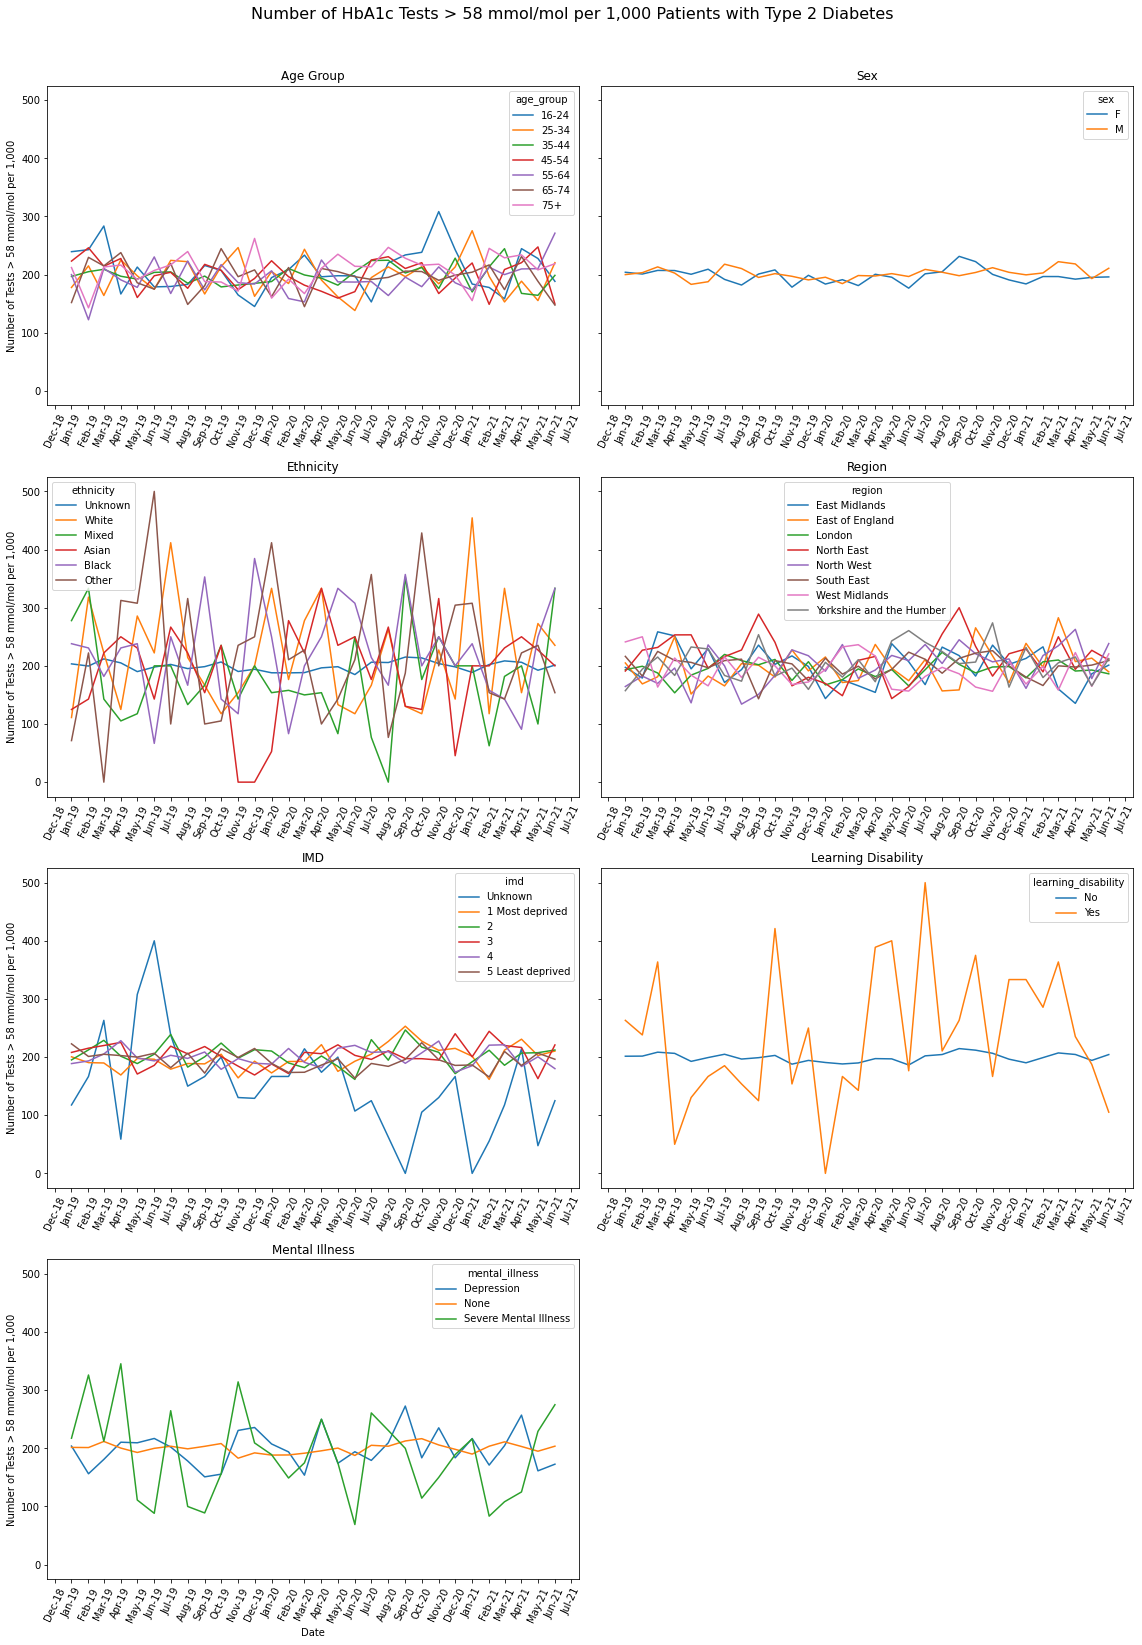

In [16]:
# > 58
create_plotgrid('tests_per_1000',li_df_t2dm_gt58, 'Number of Tests > 58 mmol/mol per 1,000',
                'gt58_t2dm_by_group', 'Number of HbA1c Tests > 58 mmol/mol per 1,000 Patients with Type 2 Diabetes')

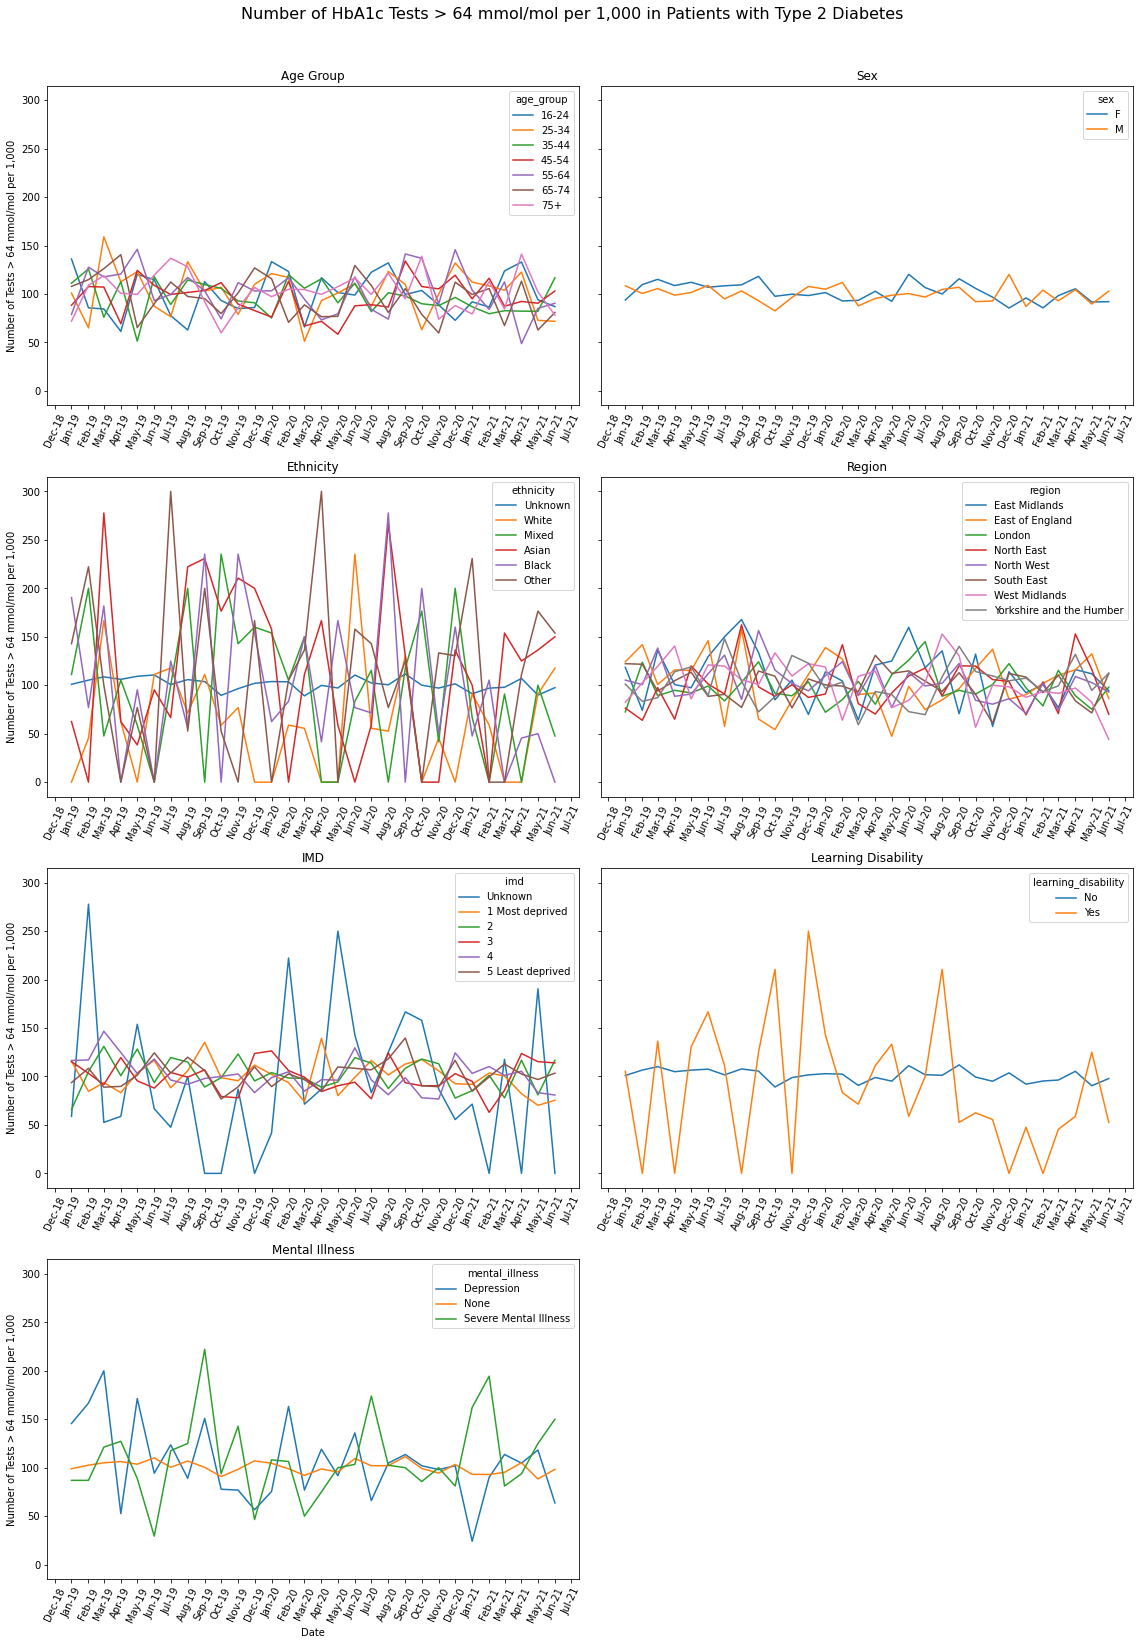

In [17]:
# > 64
create_plotgrid('tests_per_1000',li_df_t2dm_gt64, 'Number of Tests > 64 mmol/mol per 1,000',
                'gt64_t2dm_by_group','Number of HbA1c Tests > 64 mmol/mol per 1,000 in Patients with Type 2 Diabetes')

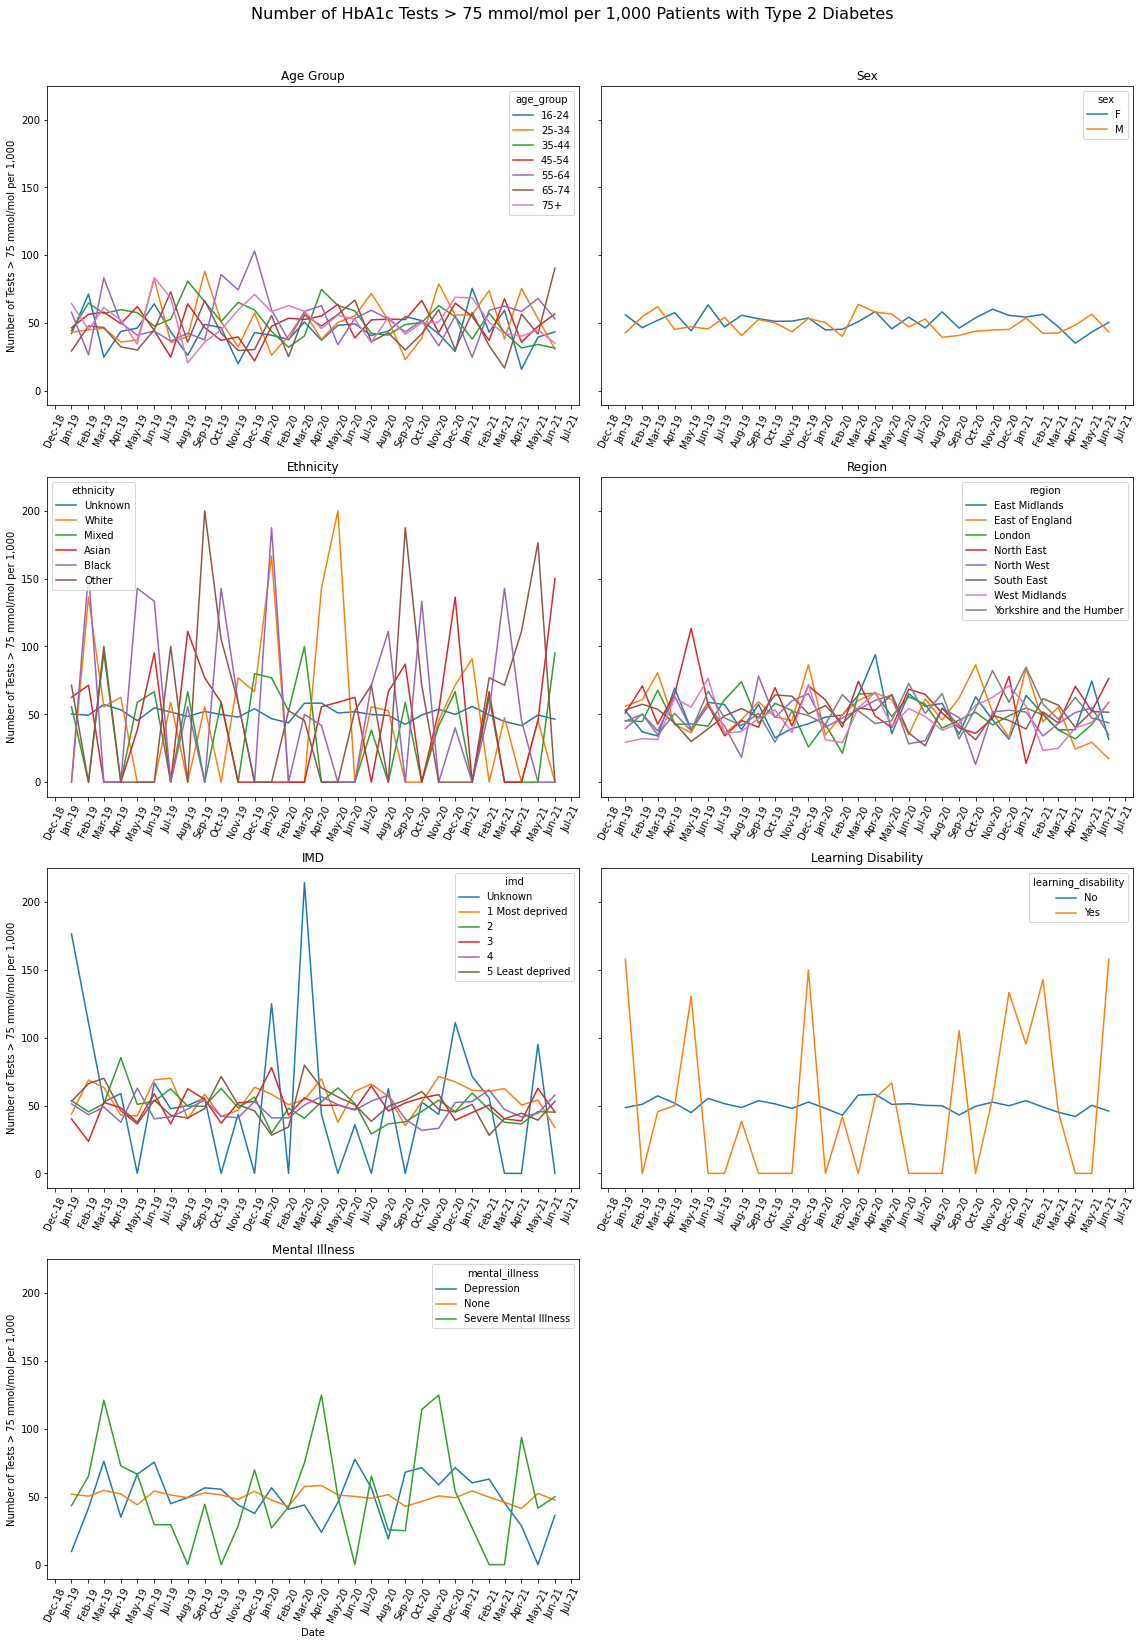

In [18]:
# > 75
create_plotgrid('tests_per_1000',li_df_t2dm_gt75, 'Number of Tests > 75 mmol/mol per 1,000',
                'gt75_t2dm_by_group','Number of HbA1c Tests > 75 mmol/mol per 1,000 Patients with Type 2 Diabetes')

___

## Percent of Tests by Target Threshold

In [19]:
# Subset to percentage variables
df_t2dm_pct = df_total_t2dm[['date','hba1c_gt_48_pct','hba1c_gt_58_pct',
                            'hba1c_gt_64_pct', 'hba1c_gt_75_pct']]

In [20]:
# Wide to long
df_t2dm_pct_wide = pd.melt(df_t2dm_pct, id_vars=['date'], value_vars=['hba1c_gt_48_pct','hba1c_gt_58_pct',
                                                                      'hba1c_gt_64_pct', 'hba1c_gt_75_pct']).reset_index(drop=True)

In [21]:
# Format variable
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_48_pct', 'variable'] = '> 48 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_58_pct', 'variable'] = '> 58 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_64_pct', 'variable'] = '> 64 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_75_pct', 'variable'] = '> 75 mmol/mol'
df_t2dm_pct_wide = df_t2dm_pct_wide.rename(columns={'variable':'threshold'})

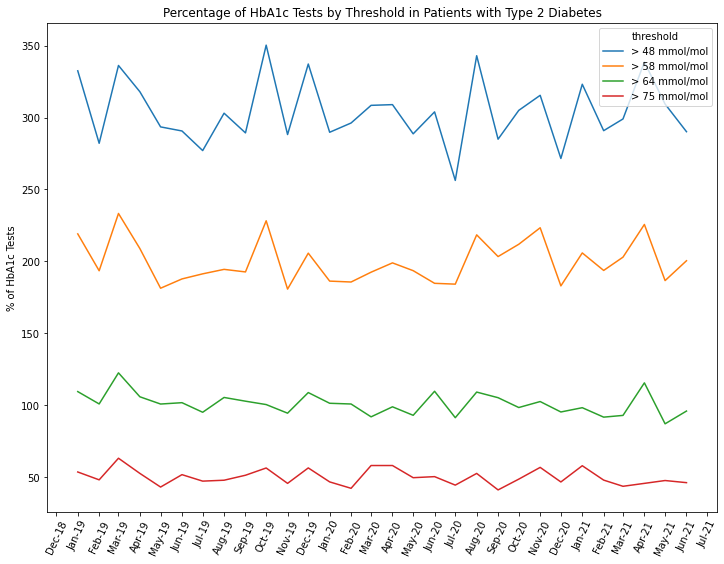

In [22]:
# Create total plot
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(x='date', y='value',
             hue='threshold', data=df_t2dm_pct_wide)
    
# Set title and make axes labels empty
ax.set_title('Percentage of HbA1c Tests by Threshold in Patients with Type 2 Diabetes')
ax.set_xlabel('')
ax.set_ylabel('% of HbA1c Tests')
ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

plt.savefig('../output/pct_t2dm.png')
plt.show()

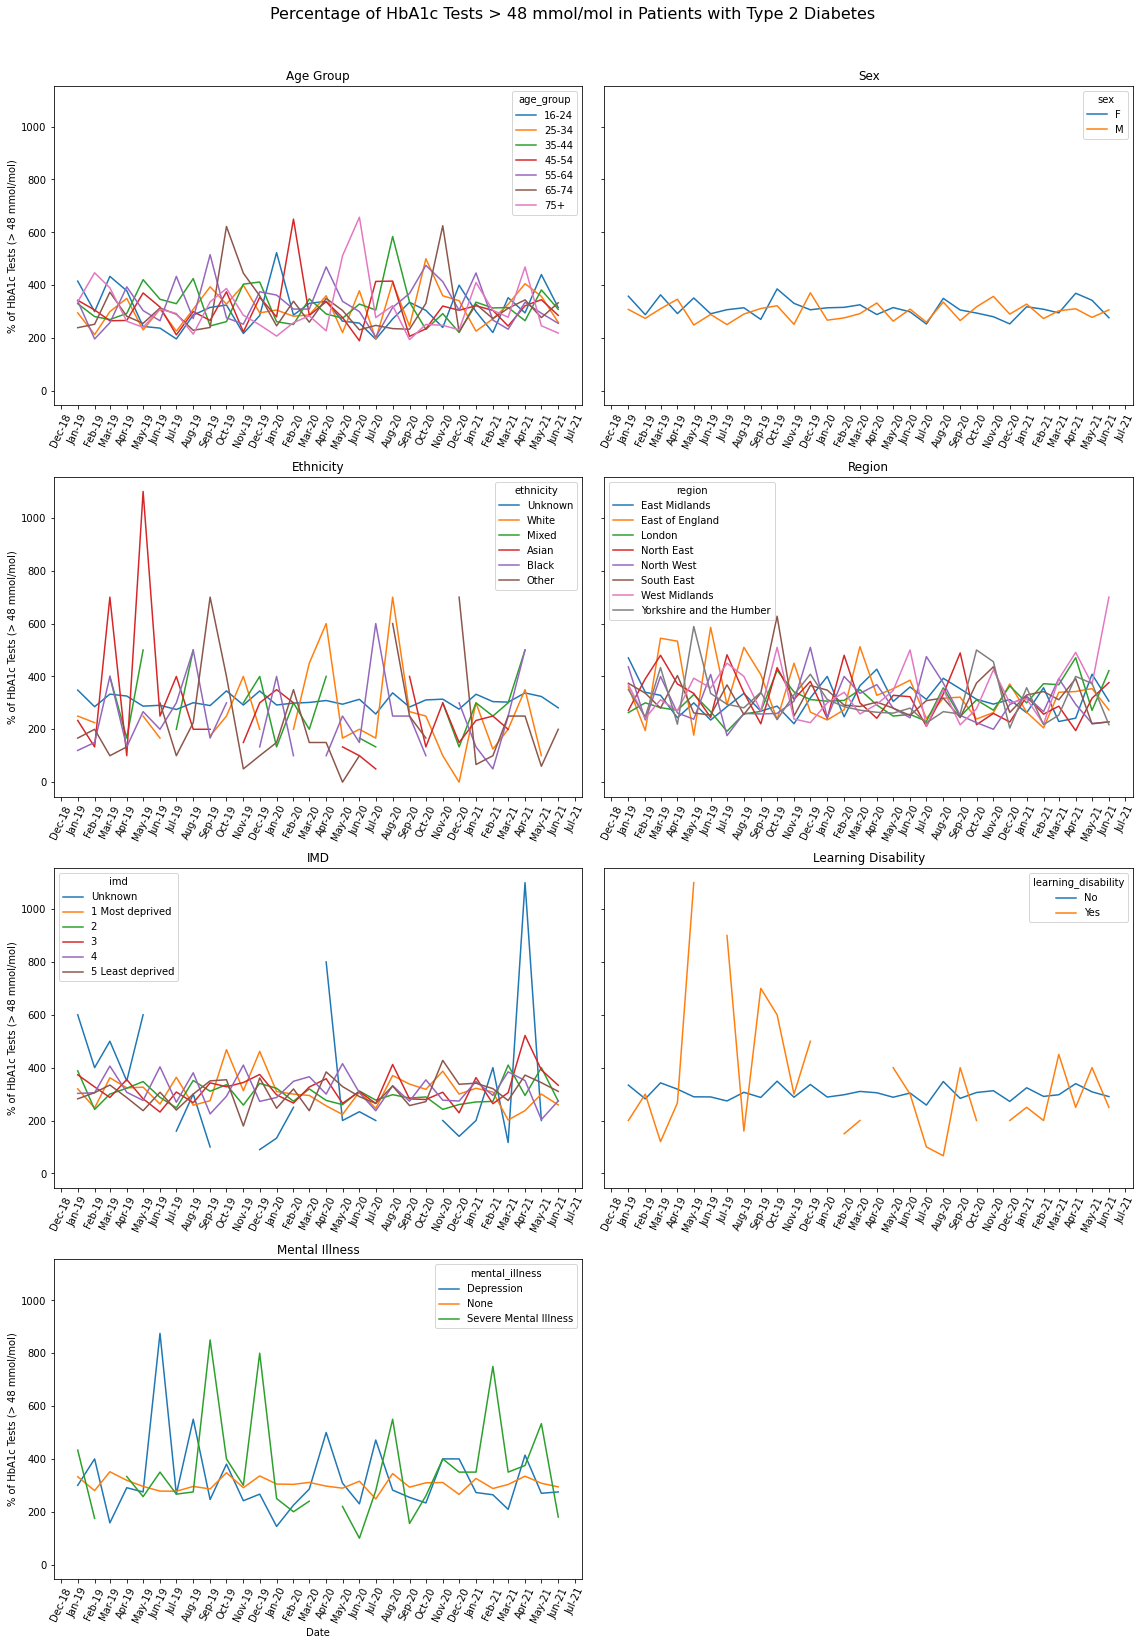

In [23]:
# > 48
create_plotgrid('hba1c_gt_48_pct',df_thresholds, '% of HbA1c Tests (> 48 mmol/mol)',
                'pct_t2dm_gt48','Percentage of HbA1c Tests > 48 mmol/mol in Patients with Type 2 Diabetes')

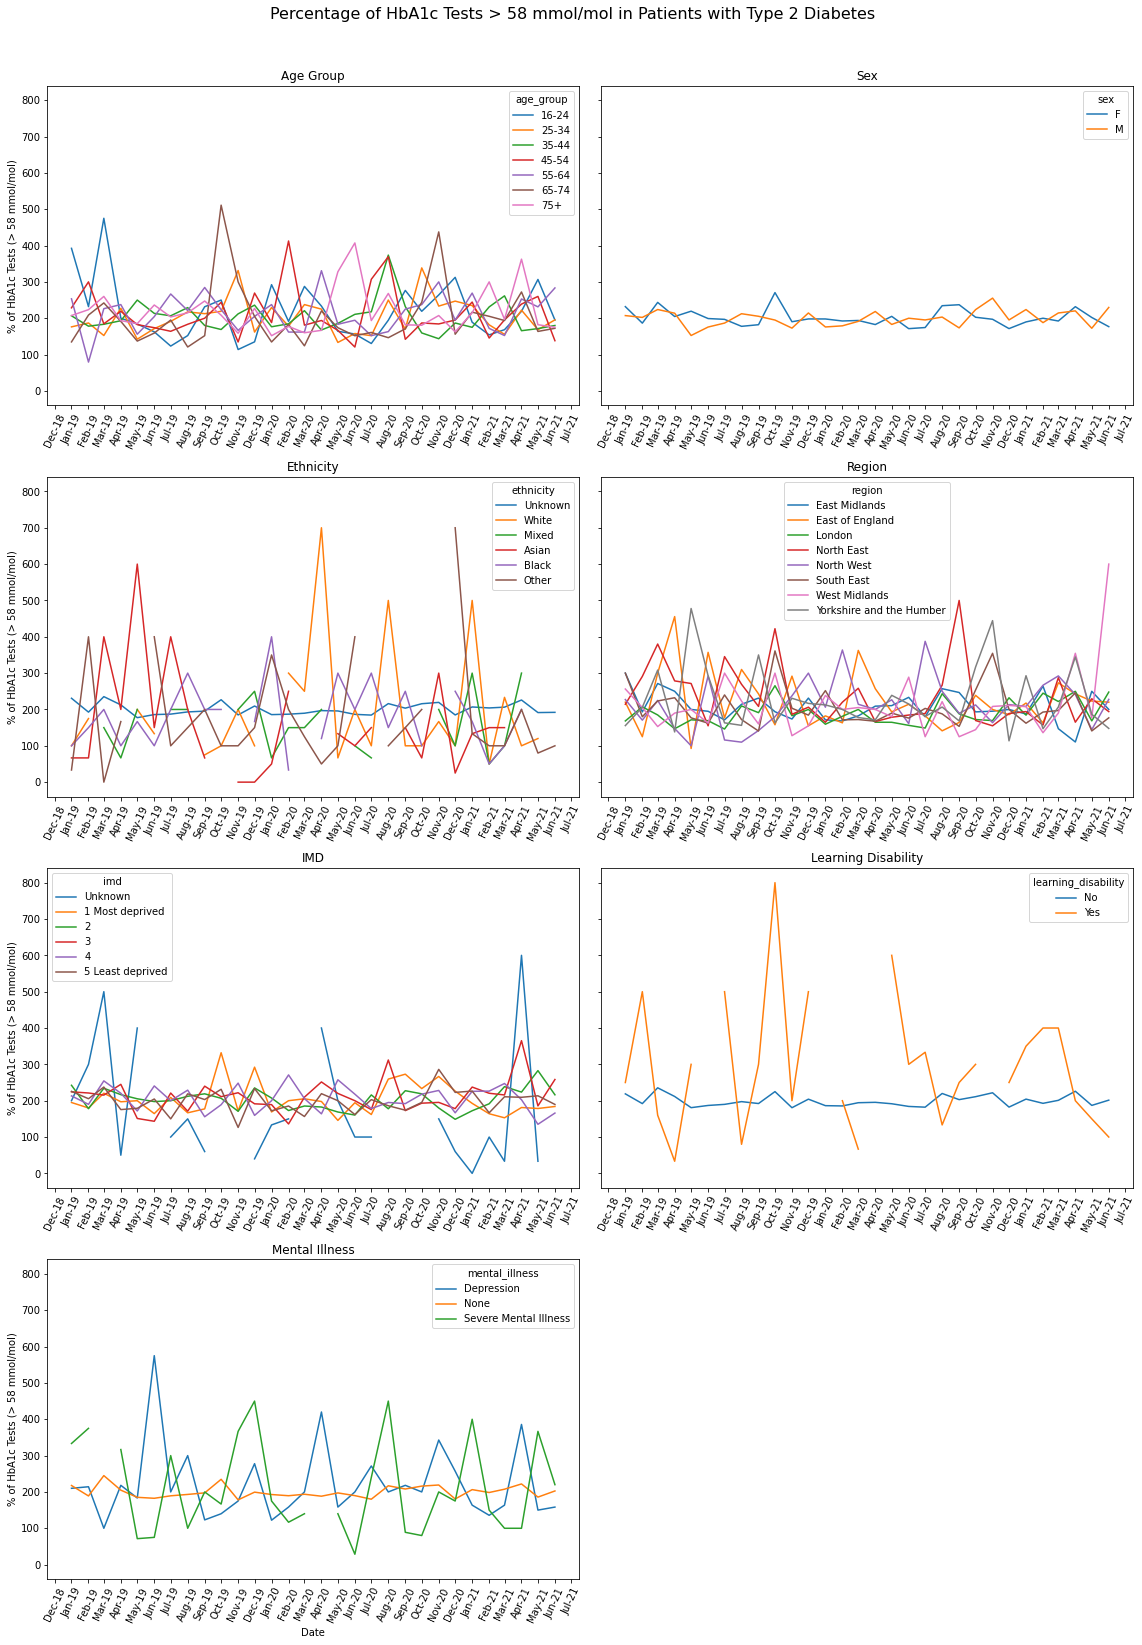

In [24]:
# > 58
create_plotgrid('hba1c_gt_58_pct',df_thresholds, '% of HbA1c Tests (> 58 mmol/mol)',
                'pct_t2dm_gt58', 'Percentage of HbA1c Tests > 58 mmol/mol in Patients with Type 2 Diabetes')

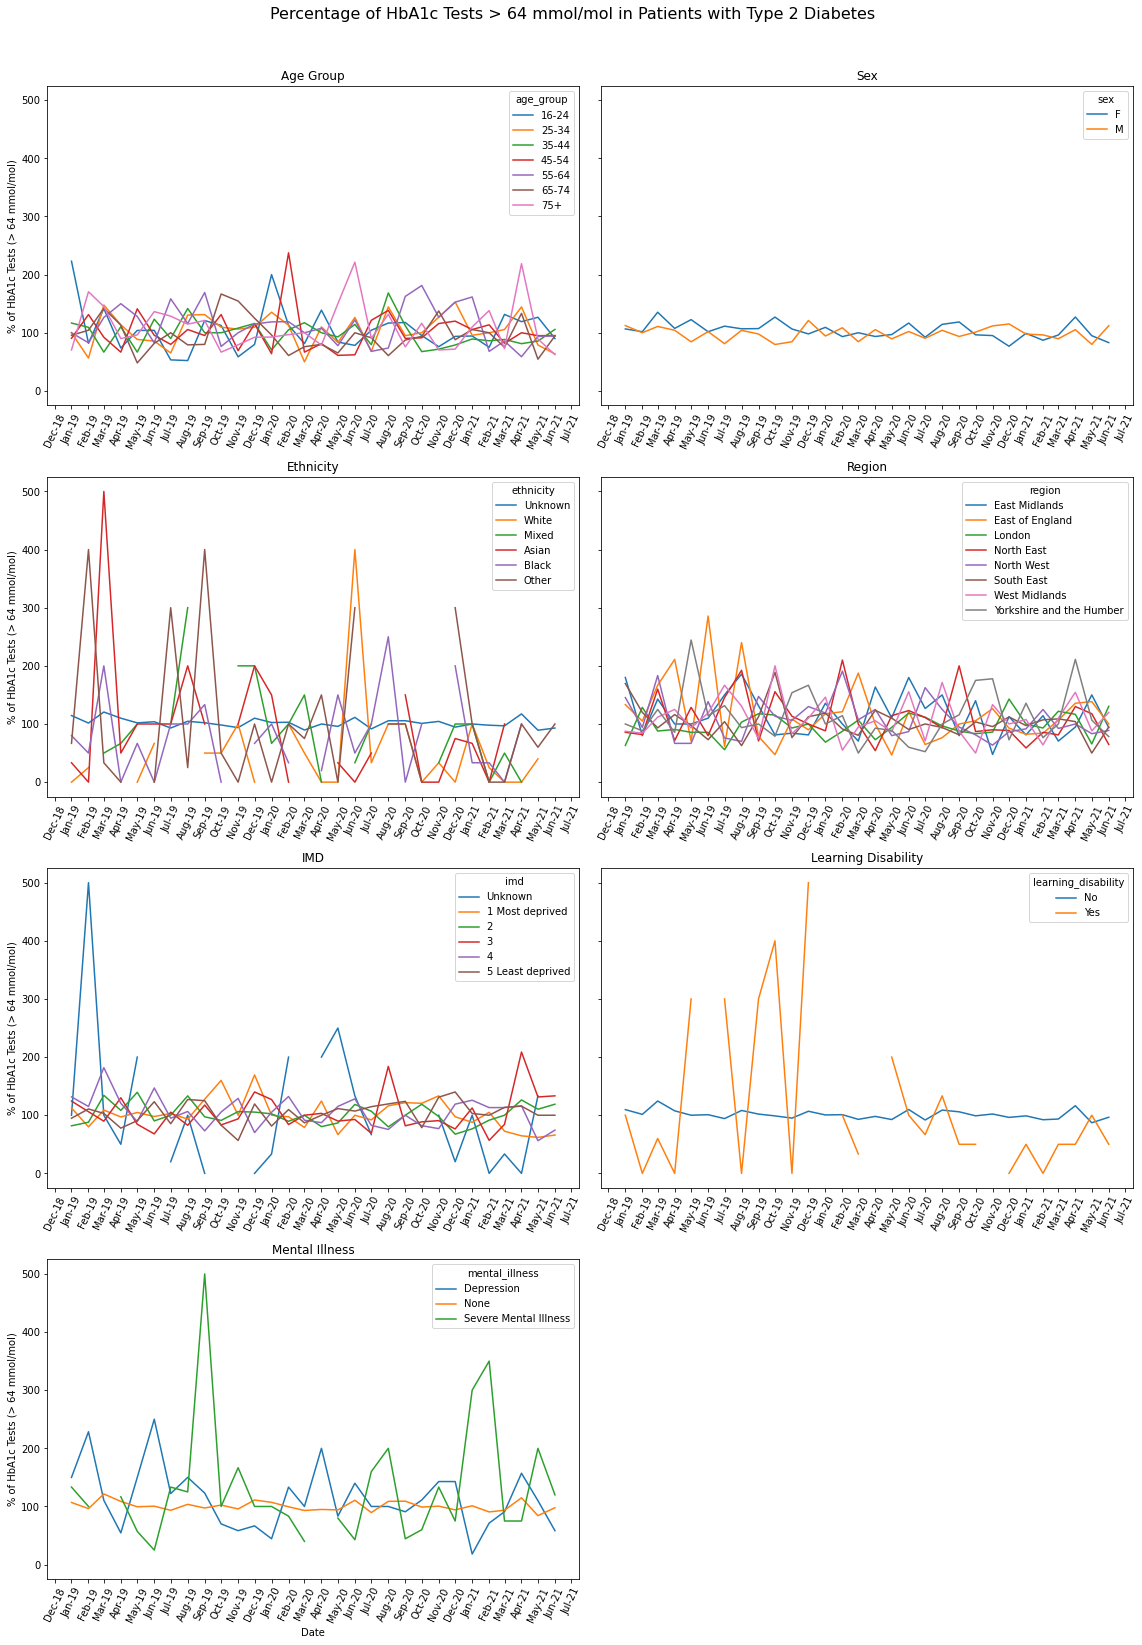

In [25]:
# > 64
create_plotgrid('hba1c_gt_64_pct',df_thresholds, '% of HbA1c Tests (> 64 mmol/mol)',
                'pct_t2dm_gt64', 'Percentage of HbA1c Tests > 64 mmol/mol in Patients with Type 2 Diabetes')

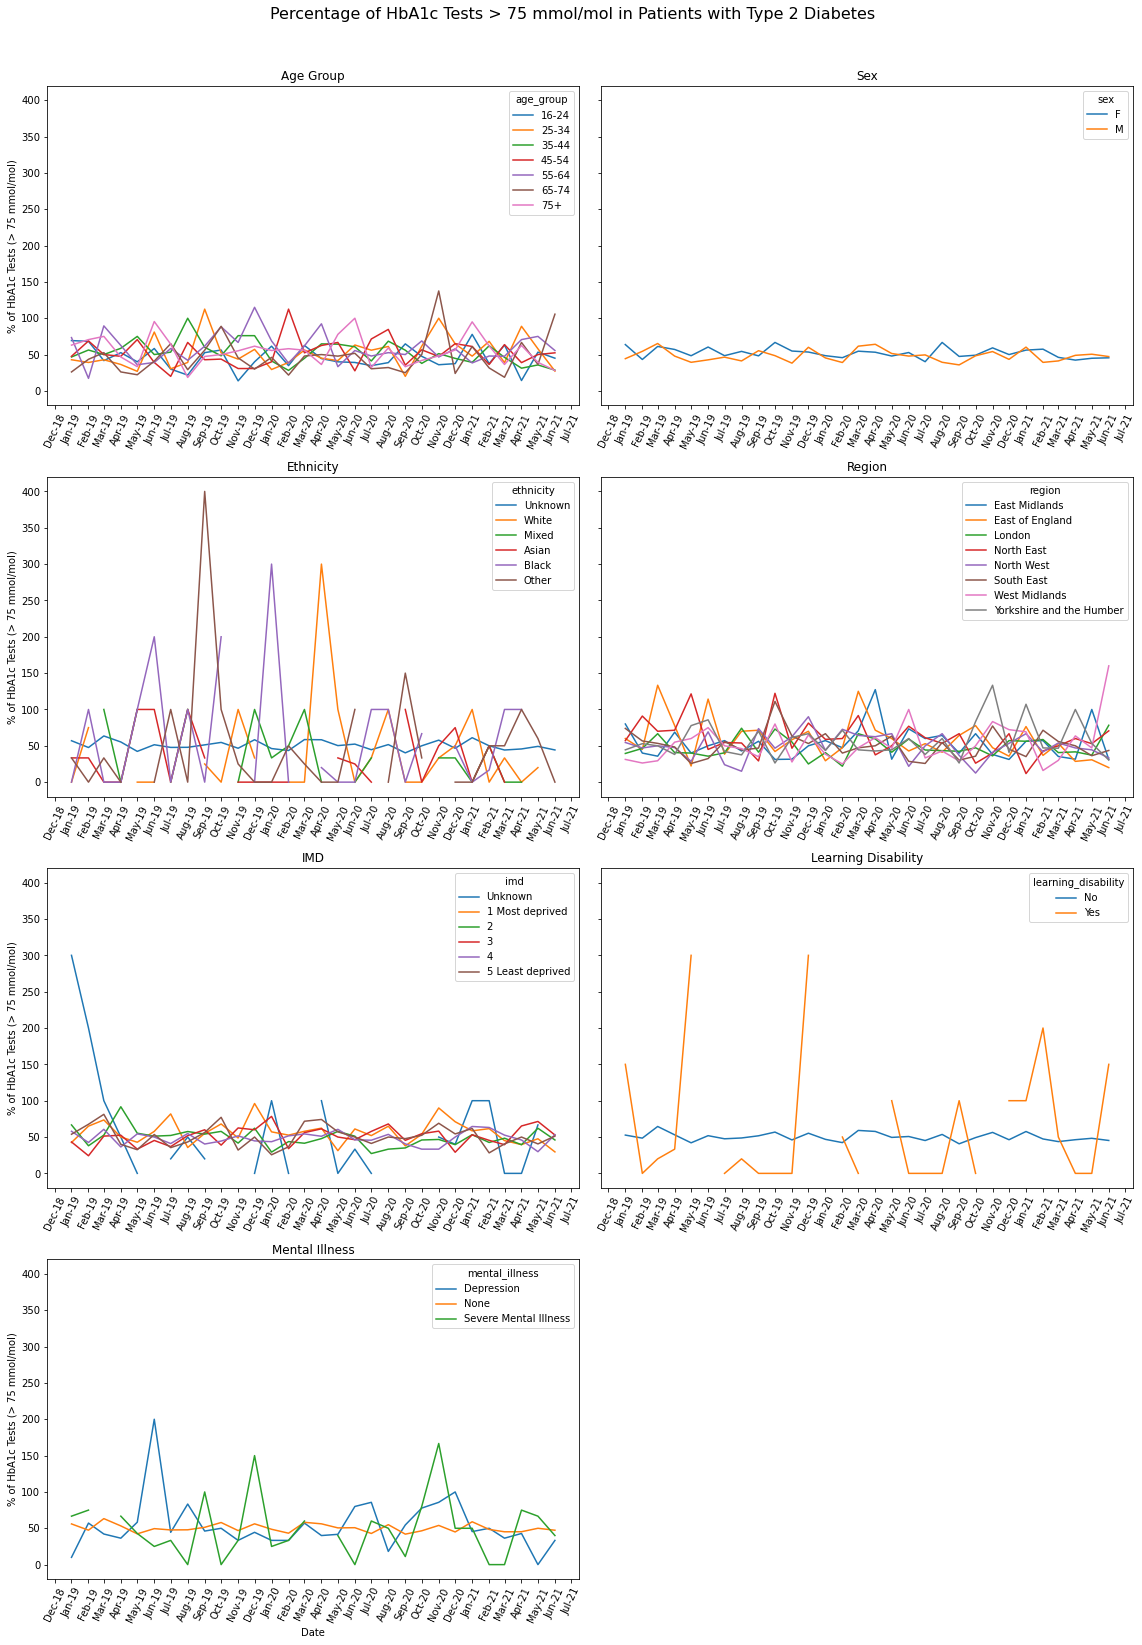

In [26]:
# > 75
create_plotgrid('hba1c_gt_75_pct',df_thresholds, '% of HbA1c Tests (> 75 mmol/mol)',
                'pct_t2dm_gt75', 'Percentage of HbA1c Tests > 75 mmol/mol in Patients with Type 2 Diabetes')

______

## Median of Test Values

In [27]:
# Read in and append input files
li = []

# Demographics
demo_vars = ['age_group', 'sex', 'ethnicity', 'region',
             'imd', 'learning_disability', 'mental_illness']

# NICE thresholds
threshold_vars = ['hba1c_gt_48', 'hba1c_gt_58', 'hba1c_gt_64', 'hba1c_gt_75']

# Import variables
import_vars = threshold_vars + demo_vars + ['patient_id', 'diabetes_type', 'took_hba1c',
                                            'prev_hba1c_mmol_per_mol', 'hba1c_mmol_per_mol']

for file in glob('../output/data/input_median*.csv'):
    df_temp = pd.read_csv(file)[import_vars]
    # Creates date variable based on file name
    df_temp['date'] = file[28:-4]
    df_temp['date'] = df_temp['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
    # Generates a count column
    df_temp['population'] = 1
    li.append(df_temp)
    
df_median = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)
df_median_t2dm = df_median.loc[df_median.diabetes_type == 'T2DM']

In [28]:
# Get patient subset with poor glycemic control prior to the pandemic
pat_subset = df_median_t2dm.loc[df_median_t2dm.prev_hba1c_mmol_per_mol > 58]['patient_id'].unique()
df_t2dm_subset = df_median_t2dm.loc[df_median_t2dm.patient_id.isin(pat_subset)]

In [29]:
# 58-74 range 
df_t2dm_subset.loc[(df_t2dm_subset.prev_hba1c_mmol_per_mol > 58) & 
                   (df_t2dm_subset.prev_hba1c_mmol_per_mol < 75), 
                   'hba1c_val_58_74'] = df_t2dm_subset.hba1c_mmol_per_mol

# > 75
df_t2dm_subset.loc[(df_t2dm_subset.prev_hba1c_mmol_per_mol > 75),
                   'hba1c_val_75'] = df_t2dm_subset.hba1c_mmol_per_mol

In [30]:
# Get median of test values
def gen_median(df_in, group=''):
    if group == '':
        df_out = df_in[['date','hba1c_val_58_74','hba1c_val_75']].groupby(['date']).median().reset_index()
    else:
        df_out = df_in[[group] + ['date','hba1c_val_58_74','hba1c_val_75']].groupby(['date', group]).median().reset_index()
    return df_out

In [31]:
df_med_t2dm = gen_median(df_t2dm_subset)
df_med_t2dm_age = gen_median(df_t2dm_subset, 'age_group')
df_med_t2dm_sex = gen_median(df_t2dm_subset, 'sex')
df_med_t2dm_eth = gen_median(df_t2dm_subset, 'ethnicity')
df_med_t2dm_reg = gen_median(df_t2dm_subset, 'region')
df_med_t2dm_imd = gen_median(df_t2dm_subset, 'imd')
df_med_t2dm_ld = gen_median(df_t2dm_subset, 'learning_disability')
df_med_t2dm_mi = gen_median(df_t2dm_subset, 'mental_illness')

In [32]:
# Format fields
df_med_t2dm_eth = df_med_t2dm_eth.replace({"ethnicity": dict_eth})
df_med_t2dm_imd = df_med_t2dm_imd.replace({'imd': dict_imd})
df_med_t2dm_ld = df_med_t2dm_ld.replace({'learning_disability': dict_ld})
df_med_t2dm_age = df_med_t2dm_age.loc[df_med_t2dm_age.age_group != '0-15']

In [33]:
df_med_t2dm_wide = pd.melt(df_med_t2dm, id_vars=['date'], value_vars=['hba1c_val_58_74', 'hba1c_val_75'])

In [34]:
# Format variable and date 
df_med_t2dm_wide.loc[df_med_t2dm_wide.variable == 'hba1c_val_58_74', 'variable'] = '58-74 mmol/mol'
df_med_t2dm_wide.loc[df_med_t2dm_wide.variable == 'hba1c_val_75', 'variable'] = '> 75 mmol/mol'
df_med_t2dm_wide = df_med_t2dm_wide.rename(columns={'variable':'range_in_prev_15_mo'})

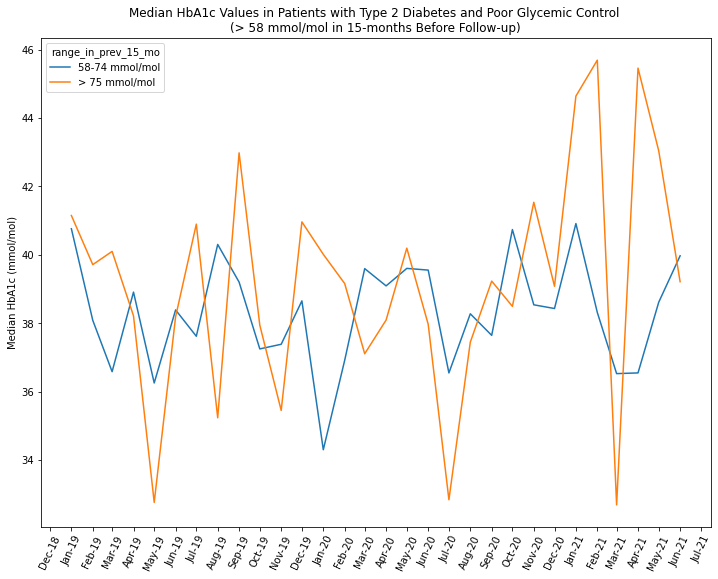

In [35]:
# Create total plot
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(x='date', y='value',
             hue='range_in_prev_15_mo', data=df_med_t2dm_wide)
    
# Set title and make axes labels empty
ax.set_title('Median HbA1c Values in Patients with Type 2 Diabetes and Poor Glycemic Control \n(> 58 mmol/mol in 15-months Before Follow-up)')
ax.set_xlabel('')
ax.set_ylabel('Median HbA1c (mmol/mol)')
ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

plt.savefig('../output/med_t2dm.png')
plt.show()

In [36]:
# List of median dfs
li_df_med_t2dm = [df_med_t2dm_age, df_med_t2dm_sex, df_med_t2dm_eth,
                  df_med_t2dm_reg, df_med_t2dm_imd, df_med_t2dm_ld, 
                  df_med_t2dm_mi]

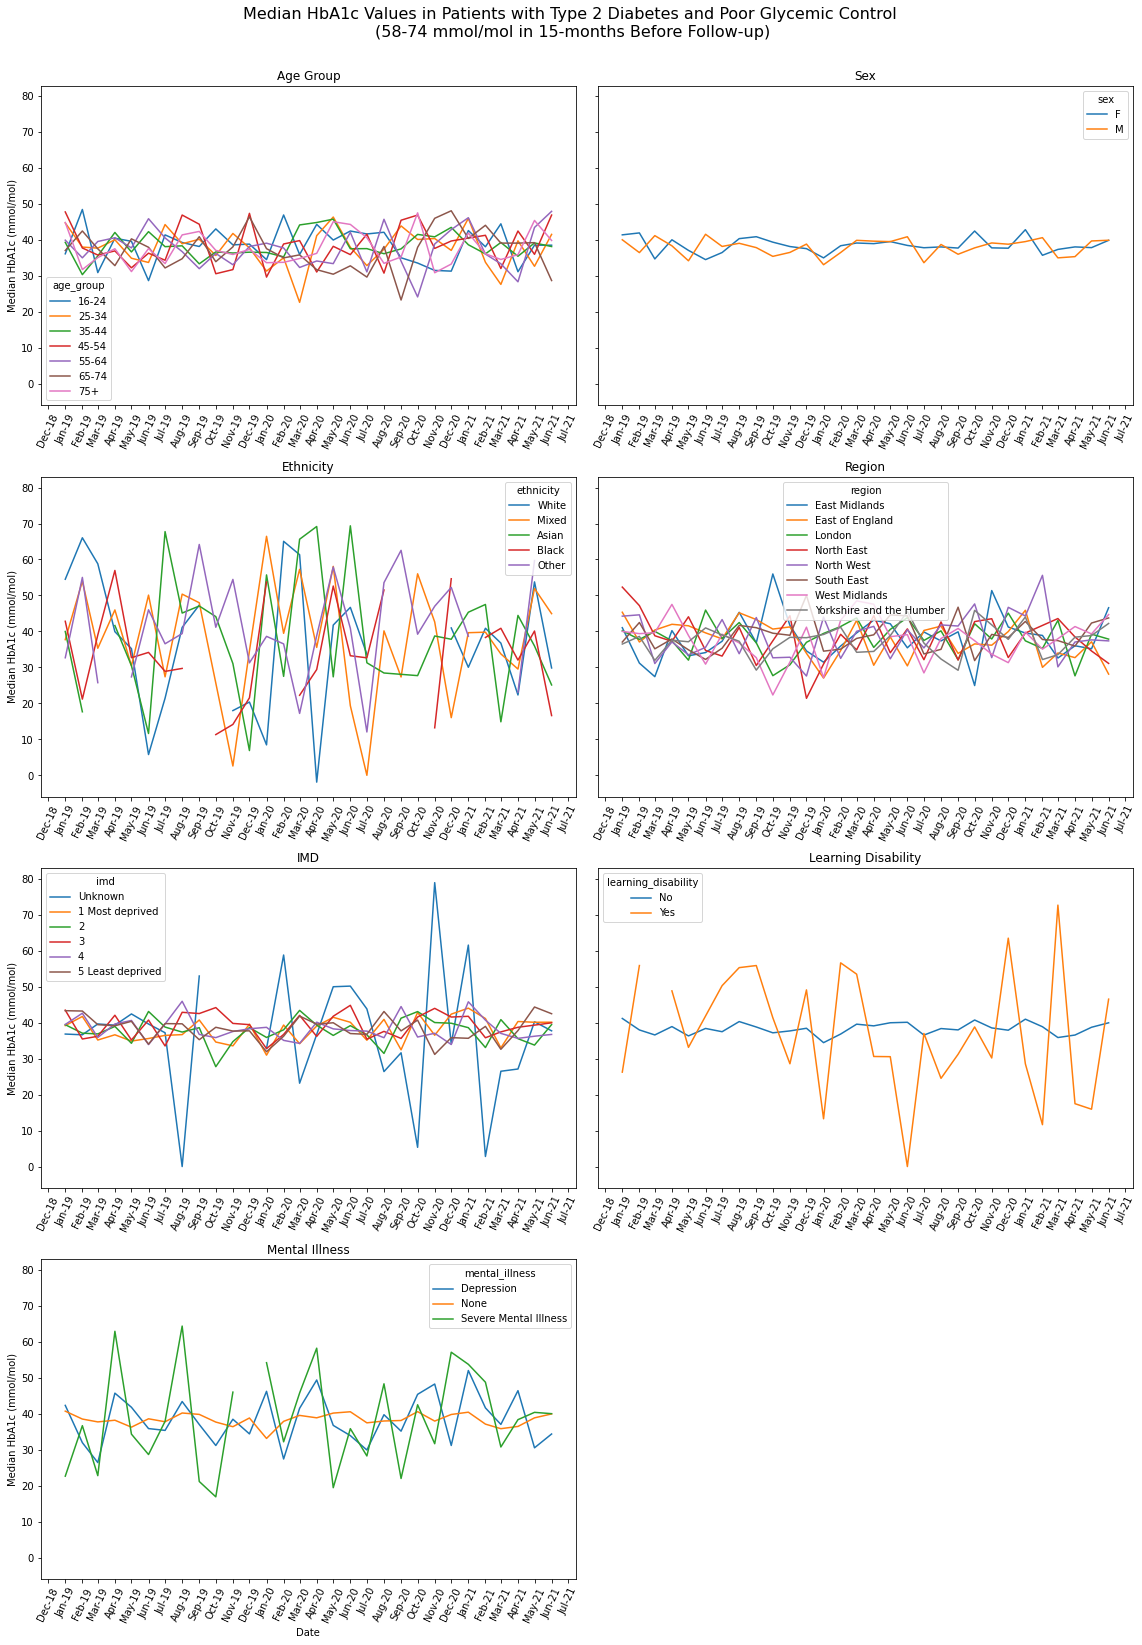

In [37]:
# 58-74 mmol/mol
create_plotgrid('hba1c_val_58_74',li_df_med_t2dm, 'Median HbA1c (mmol/mol)','med_t2dm_58_74',
                'Median HbA1c Values in Patients with Type 2 Diabetes and Poor Glycemic Control \n(58-74 mmol/mol in 15-months Before Follow-up)')

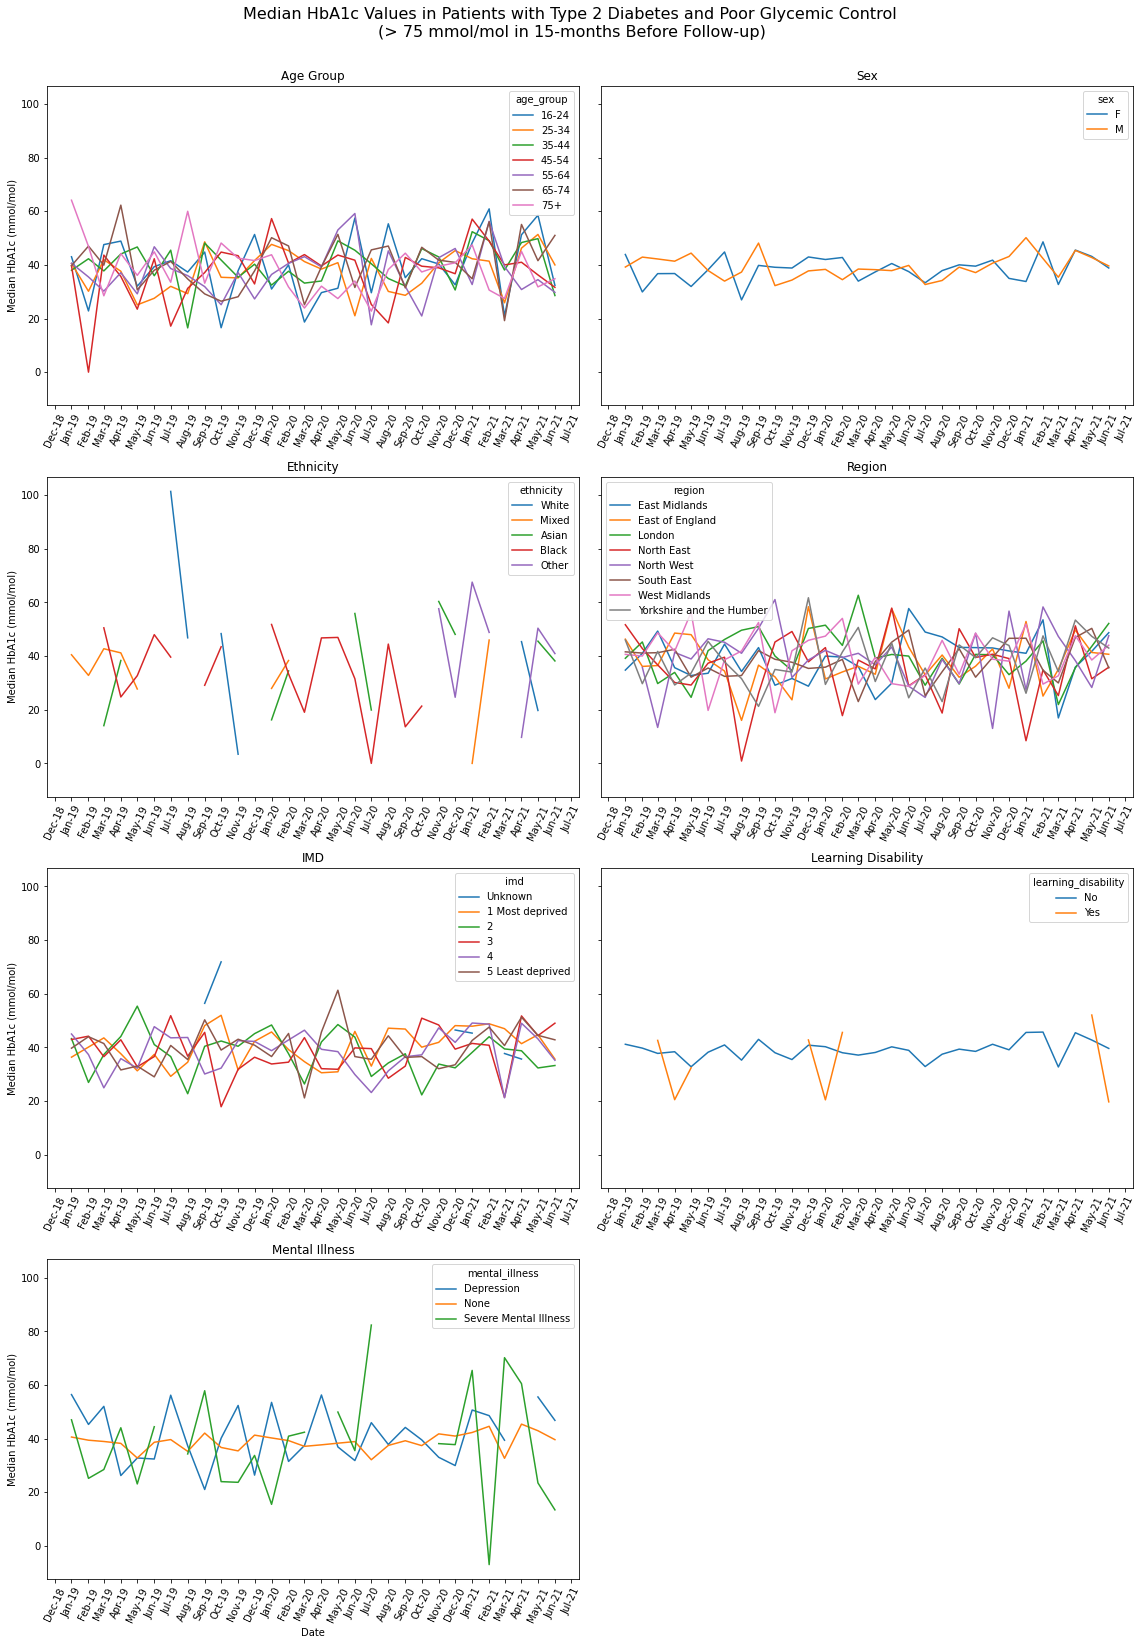

In [38]:
# > 75 mmol/mol
create_plotgrid('hba1c_val_75',li_df_med_t2dm, 'Median HbA1c (mmol/mol)','med_t2dm_gt75',
                'Median HbA1c Values in Patients with Type 2 Diabetes and Poor Glycemic Control \n(> 75 mmol/mol in 15-months Before Follow-up)')